In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD


In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from tqdm import tqdm

In [4]:
import models
architecture = getattr(models, "Linear3NoBias") #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    True,
    train_random=False,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/Linear3NoBias/curve4/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/Linear3NoBias/curve5/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
# model1.cuda()
# model2.cuda()
# stat = {'train': [], 'test': []}
# for i in tqdm(range(3, 11)):
#     model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
#     res = test_model(model1, loaders, cuda=True)
#     stat['train'].append(res[0]['accuracy'])
#     stat['test'].append(res[1]['accuracy'])


In [6]:
# np.array(stat['train']).std(), np.array(stat['test']).std()

In [7]:
# model1.cuda();
# model1.eval();
# test_model(model1, loaders, cuda=True)

In [8]:
# model2.cuda();
# model2.eval();
# test_model(model2, loaders, cuda=True)

In [9]:
def get_data(data_type='train'):

    layer = 0
    model1.cuda()
    model1.eval()
    functions = []
    targ = []
    data = []
    for X, y in loaders[data_type]:
        data.append(X.view(-1,3*32*32).cpu().data.numpy())
        functions.append(model1(X.cuda(), N=layer))
        targ.append(y)


    print('l', functions[0].shape)
    data = np.concatenate(data)
    targ = np.concatenate(targ)
    funcs = np.concatenate([p.cpu().data.numpy() for p in functions])
    
    return data, targ, funcs

In [10]:
data, targ, _ = get_data(data_type='train')

l torch.Size([1024, 6144])


In [11]:
data.shape, targ.shape

((50000, 3072), (50000,))

In [12]:
data_test, targ_test, _ = get_data(data_type='test')

l torch.Size([1024, 6144])


In [13]:
# W10 = list(model1.parameters())[0].data.cpu().numpy()
# W20 = list(model2.parameters())[0].data.cpu().numpy()

# W11 = list(model1.parameters())[-2].data.cpu().numpy()
# W21 = list(model2.parameters())[-2].data.cpu().numpy()

# W12 = list(model1.parameters())[-1].data.cpu().numpy()
# W22 = list(model2.parameters())[-1].data.cpu().numpy()

In [14]:
def next_layer(W, data):
    funcs = np.maximum(data @ W.T, 0)
    return funcs

    
def accuracy(pred, targ):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    return ens_acc

In [15]:
# data = data[:2000]
# targ = targ[:2000]

In [16]:
# pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11 @ np.maximum(W10 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [17]:
# pred = W22 @ np.maximum(W21 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W22 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [18]:
# funcs1 = next_layer(W10, data=data)
# funcs2  = next_layer(W20, data=data)

In [19]:
# f_inv2 = np.linalg.pinv(funcs2.T)
# W11b2 = W11 @ funcs1.T @ f_inv2

In [20]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [21]:
# funcs12 = next_layer(W11, data=funcs1)
# funcs22  = next_layer(W21, data=funcs2)

In [22]:
# f_inv22 = np.linalg.pinv(funcs22.T)
# W12b2 = W12 @ funcs12.T @ f_inv22

In [23]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12b2 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [24]:
# print(W10.shape, W11.shape, W12.shape)

In [25]:
class PointFinder():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs1 = next_layer(self.W10, data=data)
        self.funcs2  = next_layer(self.W20, data=data)
        self.f_inv2 = np.linalg.pinv(self.funcs2.T)
        self.W11b2 = self.W11 @ self.funcs1.T @ self.f_inv2

    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            Wn1 = getattr(Connector(self.W11.T, self.W11b2.T), method)(t=s)[1].T
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
        elif 1<=t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
            Wn2 = getattr(Connector(self.W12.T, self.W22.T), method)(t=s)[1].T
            
            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
  
        else:
            assert not  0<=t<=2, 't is not in [0, 2]'

        return out

In [26]:
class PointFinderInverse():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs11 = next_layer(self.W10, data=data)
        self.funcs12 = next_layer(self.W11, data=self.funcs11)
        
        self.funcs21 = next_layer(self.W20, data=data)
        self.funcs22 = next_layer(self.W21, data=self.funcs21)
        
        self.f_inv21 = np.linalg.pinv(self.funcs21.T)
        self.W11b2 = self.W11 @ self.funcs11.T @ self.f_inv21
        
        self.f_inv22 = np.linalg.pinv(self.funcs22.T)
        self.W12b2 = self.W12 @ self.funcs12.T @ self.f_inv22
        
    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            
            funcs = next_layer(Wn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)

        elif 1<t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]

            funcs = next_layer(Wn1, data=self.funcs21)
            f_inv = np.linalg.pinv(funcs.T)
            Wn2 = self.W12 @ self.funcs12.T @ f_inv

            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        elif 2<t<=3:
            s = t - 2
            Wn1 = getattr(Connector(self.W12b2, self.W22), method)(t=s)[1]
               
            pred = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        else:
            assert not  0<=t<=3, 't is not in [0, 3]'
            
        print(t, out)

        return out

# Path Visualization 

In [27]:
# finder = PointFinderInverse(model1, model2) 
finder = PointFinder(model1, model2)

In [28]:
point = finder.find_point(t=0, method='arc_connect')

In [48]:
point

{'train': 96.1, 'test': 63.44}

In [71]:
point1 = finder.find_point(t=1, method='arc_connect')
point1

{'train': 96.1, 'test': 62.3}

In [72]:
point2 = finder.find_point(t=2, method='arc_connect')
point2

{'train': 96.1, 'test': 10.79}

In [74]:
point3 = finder.find_point(t=2.5, method='arc_connect')
point3

{'train': 97.39999999999999, 'test': 11.51}

In [29]:
time = np.linspace(0, 2, 61)

In [30]:
time

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        ])

In [31]:
point

{'train': 95.27799999999999, 'test': 63.44}

In [32]:
path = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='arc_connect')
    path['test'].append(100-point['test']) 
    path['train'].append(100-point['train']) 

100%|██████████| 61/61 [07:53<00:00,  7.54s/it]


In [33]:
100 - np.array(path['train'])

array([95.278, 95.176, 94.816, 94.184, 93.272, 92.132, 90.574, 88.748,
       86.85 , 84.878, 83.174, 81.562, 80.17 , 79.066, 78.35 , 77.956,
       77.96 , 78.39 , 79.176, 80.222, 81.494, 83.054, 84.726, 86.518,
       88.244, 89.828, 91.184, 92.26 , 93.052, 93.48 , 93.63 , 93.216,
       91.872, 89.888, 87.254, 84.062, 80.75 , 76.952, 73.412, 70.04 ,
       67.074, 64.836, 62.96 , 61.73 , 60.99 , 60.978, 61.612, 62.69 ,
       64.364, 66.658, 69.38 , 72.434, 76.17 , 79.816, 83.54 , 87.012,
       89.808, 92.152, 93.822, 94.752, 95.036])

In [34]:
100 - np.array(path['test'])

array([63.44, 63.49, 63.31, 63.  , 62.7 , 62.23, 61.8 , 61.2 , 60.61,
       60.05, 59.17, 58.76, 58.24, 57.75, 57.56, 57.52, 57.59, 57.74,
       58.12, 58.68, 59.11, 59.89, 60.37, 61.05, 61.66, 62.31, 62.72,
       62.99, 63.1 , 63.18, 63.36, 63.11, 62.49, 61.8 , 60.83, 59.69,
       58.47, 57.31, 56.18, 54.92, 53.68, 52.34, 51.26, 50.65, 50.57,
       50.42, 50.39, 51.11, 51.91, 52.98, 54.38, 56.04, 57.19, 58.5 ,
       59.86, 60.95, 61.88, 62.52, 63.2 , 63.43, 63.64])

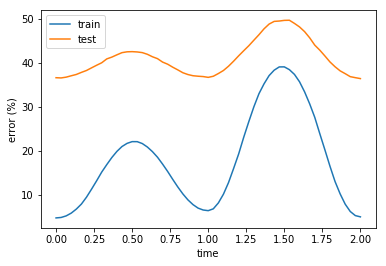

In [35]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [36]:
path_l = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='lin_connect')
    path_l['test'].append(100-point['test']) 
    path_l['train'].append(100-point['train']) 

100%|██████████| 61/61 [07:43<00:00,  7.45s/it]


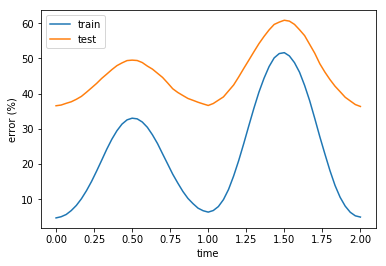

In [37]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [45]:
def get_stat(pointfinder, t=1.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(3, 9)):
        model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [46]:
arcbutterfly = get_stat(PointFinder, t=1.5, method='arc_connect')


100%|██████████| 6/6 [12:07<00:00, 121.25s/it]


In [49]:
arcbutterfly

{'test': [48.77, 50.42, 49.46, 51.32, 49.09, 48.82],
 'train': [59.931999999999995,
  60.978,
  60.397999999999996,
  62.21600000000001,
  60.01,
  60.124]}

In [52]:
def get_mean_svd(stat):
    train = np.array(stat['train'])
    test = np.array(stat['test'])
    return train.mean(), train.std(), test.mean(), test.std()

In [53]:
get_mean_svd(arcbutterfly)

(60.60966666666667, 0.7974420912448094, 49.64666666666667, 0.930477774527091)

In [54]:
linbutterfly = get_stat(PointFinder, t=1.5, method='lin_connect')


100%|██████████| 6/6 [12:06<00:00, 121.03s/it]


In [55]:
linbutterfly

{'test': [36.93, 39.17, 39.379999999999995, 39.21, 38.12, 37.75],
 'train': [46.738,
  48.374,
  48.087999999999994,
  49.036,
  47.355999999999995,
  47.326]}

In [56]:
get_mean_svd(linbutterfly)

(47.81966666666667, 0.7623922146040647, 38.42666666666667, 0.9006417465094294)

In [57]:
linpseudo = get_stat(PointFinderInverse, t=1.5, method='lin_connect')


 17%|█▋        | 1/6 [02:26<12:13, 146.64s/it]

1.5 {'train': 61.026, 'test': 51.839999999999996}



 33%|███▎      | 2/6 [04:53<09:46, 146.74s/it]

1.5 {'train': 60.948, 'test': 51.64}



 50%|█████     | 3/6 [07:20<07:20, 146.78s/it]

1.5 {'train': 60.784000000000006, 'test': 51.68000000000001}



 67%|██████▋   | 4/6 [09:47<04:53, 146.83s/it]

1.5 {'train': 61.419999999999995, 'test': 52.18000000000001}



 83%|████████▎ | 5/6 [12:14<02:26, 146.83s/it]

1.5 {'train': 60.846000000000004, 'test': 52.23}



100%|██████████| 6/6 [14:41<00:00, 146.84s/it]


1.5 {'train': 60.57599999999999, 'test': 51.68000000000001}


In [63]:
linpseudo

{'test': [51.839999999999996,
  51.64,
  51.68000000000001,
  52.18000000000001,
  52.23,
  51.68000000000001],
 'train': [61.026,
  60.948,
  60.784000000000006,
  61.419999999999995,
  60.846000000000004,
  60.57599999999999]}

In [64]:
get_mean_svd(linpseudo)

(60.93333333333334, 0.2592493437257302, 51.875, 0.2420571557848809)

In [ ]:
arcpseudo = get_stat(PointFinderInverse, t=1.5, method='arc_connect')


 17%|█▋        | 1/6 [02:26<12:14, 146.96s/it]

1.5 {'train': 71.096, 'test': 59.47}


In [65]:
arcpseudo

{'test': [59.47,
  59.38,
  58.540000000000006,
  58.95,
  58.650000000000006,
  58.699999999999996],
 'train': [71.096, 71.356, 70.706, 71.394, 71.134, 70.922]}

In [66]:
get_mean_svd(arcpseudo)

(71.10133333333334,
 0.23806628395376653,
 58.94833333333333,
 0.35960240389753795)

In [59]:
f_inv1 = np.linalg.pinv(funcs1.T)

In [60]:
f_inv2 = np.linalg.pinv(funcs2.T)

In [62]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [70]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [64]:
t=0.5
pred = Connector(W12.T, W22.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W11, (W21 @ funcs2.T @ f_inv1)).arc_connect(t=t)[1] @  np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

61.07

In [65]:
t = 0.5
pred = W22 @ np.maximum(Connector((W21 @ funcs2.T @ f_inv1).T, W21.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W10, W20).arc_connect(t=t)[1]  @ data.T, 0), 0)
accuracy(pred.T, targ)

78.448